In [1]:
import uproot
import numpy as np
import numba
import awkward1 as ak

from utils import plot

cms_dict = uproot.open("/Users/herwig/Desktop/dominic/data/nanoAOD.root")["Events"].arrays()
cms_dict_ak1 = {name.decode(): ak.from_awkward0(array) for name, array in cms_dict.items()}

cms_events = ak.zip({
    "genParticles": ak.zip({
        "pt":     cms_dict_ak1["GenPart_pt"],
        "eta":    cms_dict_ak1["GenPart_eta"],
        "phi":    cms_dict_ak1["GenPart_phi"],
        "mass":   cms_dict_ak1["GenPart_mass"],
        "status": cms_dict_ak1["GenPart_status"],
        "mother": cms_dict_ak1["GenPart_genPartIdxMother"],
        "pdgId":  cms_dict_ak1["GenPart_pdgId"],
    }),
    "electrons": ak.zip({
        "dxy"        : cms_dict_ak1["Electron_dxy"],
        "dxyErr"     : cms_dict_ak1["Electron_dxyErr"],
        "dz"         : cms_dict_ak1["Electron_dz"],
        "dzErr"      : cms_dict_ak1["Electron_dzErr"],
        "eta"        : cms_dict_ak1["Electron_eta"],
        "ip3d"       : cms_dict_ak1["Electron_ip3d"],
        "mass"       : cms_dict_ak1["Electron_mass"],
        "phi"        : cms_dict_ak1["Electron_phi"],
        "pt"         : cms_dict_ak1["Electron_pt"],
        "charge"     : cms_dict_ak1["Electron_charge"],
        "pdgId"      : cms_dict_ak1["Electron_pdgId"],
        "genPartIdx" : cms_dict_ak1["Electron_genPartIdx"],
        "genPartFlav": cms_dict_ak1["Electron_genPartFlav"],
    })
}, depth_limit=1)



In [2]:
@numba.jit
def truth_link(gen_parts_per_event, builder):
    # first fill a dictionary containing every electron like
    # daughter_dict[mother idx] = daughter idx
    # where each are electrons
    # if an ele daughter doesn't exist, give -1 index
    # assumes multiple electrons can't have the same mother
    
    for gen_parts in gen_parts_per_event:
        builder.begin_list()
        
        ele_mothers={} # store mother indices
        for i in range(len(gen_parts)):            
            if np.abs(gen_parts[i].pdgId)==11:
                ele_idx = i
                mother_idx = gen_parts[ele_idx].mother
                ele_mothers[ele_idx] = mother_idx if np.abs(gen_parts[mother_idx].pdgId)==11 else -1
                while(mother_idx>=0 and np.abs(gen_parts[mother_idx].pdgId)==11):
                    # step through mother tree, filling dict along the way
                    ele_idx = mother_idx
                    mother_idx = gen_parts[ele_idx].mother
                    ele_mothers[ele_idx]=mother_idx

        first_ancestor={} # store first ancestor with the same pdgId
        for e_idx in ele_mothers:
            idx = e_idx
            while idx in ele_mothers and ele_mothers[idx]>=0:
                idx = ele_mothers[idx]
            # (idx mother should now be -1)
            first_ancestor[e_idx] = idx
        
        for i in range(len(gen_parts)):            
            isFirst=False
            isLast=False
            motherPdgId=0

            # record mother IDs, including those from the first ele even in the case of subseq eles
            if gen_parts[i].mother>=0:
                if i in first_ancestor:
                    motherPdgId = gen_parts[gen_parts[first_ancestor[i]].mother].pdgId
                else:
                    motherPdgId = gen_parts[gen_parts[i].mother].pdgId
                
            if np.abs(gen_parts[i].pdgId)==11:
                if i in set(ele_mothers.keys()) and ele_mothers[i]<0:
                    #has no mother
                    isFirst=True
                if not (i in set(ele_mothers.values())):
                    #no ones mother
                    isFirst=True
            
            builder.begin_record()
            builder.field("isFirst")
            builder.append(isFirst)
            builder.field("isLast")
            builder.append(isLast)
            builder.field("motherPdgId")
            builder.append(motherPdgId)
            builder.end_record()

        builder.end_list()
    return builder



In [3]:
drawInputHistograms=False
if drawInputHistograms:
    for collection in cms_events.columns:
        n_objs = ak.num(cms_events[collection]['pt'])
        plot(n_objs,"n_"+collection, xtitle=collection+" multiplicity")
        for attr in cms_events[collection].columns:
            flat_values = ak.flatten(ak.to_list(cms_events[collection][attr]))
            plot(flat_values,collection+'_'+attr, xtitle=collection+" "+attr)

In [4]:
# DEFINE THE TRUTH ELECTRONS                                                                                                                                                                          
# derived array with extra truth information                                                                                                                                                          
truth_builder = truth_link(cms_events['genParticles'], ak.ArrayBuilder())
truth_extension = truth_builder.snapshot()
ele_mask = np.abs(cms_events['genParticles']['pdgId']) == 11
first_mask = truth_extension['isFirst']
last_mask = np.abs(cms_events['genParticles']['status']) == 1 # equivalent to last                                                                                                                    
z_mask = truth_extension['motherPdgId'] == 23
n2_mask = truth_extension['motherPdgId'] == 1000023
gen_ele_mask = ele_mask & (z_mask | n2_mask) & last_mask
truth_electrons = cms_events['genParticles'][gen_ele_mask]


In [5]:
drawTruthElectrons=False
if drawTruthElectrons:
    plot(ak.num(genEles),"n_genElectrons", xtitle="gen electron multiplicity")
    for attr in genEles.columns:
        plot(ak.flatten(ak.to_list(genEles[attr])),'genElectron_'+attr, xtitle="Gen Electron "+attr)

In [6]:
reco_electrons = cms_events['electrons']

In [7]:
#pairs = ak.cartesian(truth_electrons, reco_electrons)
pairs = ak.cartesian( [truth_electrons, reco_electrons] )

In [51]:
print(ak.num(truth_electrons))
print(ak.num(reco_electrons))
print(ak.num(pairs))
evt_mask = ak.num(truth_electrons)==2

[2, 0, 2, 0, 0, 2, 0, 2, 0, 2, 2, 2, 2, 2, ... 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2]
[0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 2, 1, 1, ... 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2]
[0, 0, 2, 0, 0, 2, 0, 2, 0, 2, 2, 4, 2, 2, ... 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 4]


In [52]:
t, r = ak.unzip(pairs)

In [53]:
dR = np.sqrt((t.eta - r.eta)**2 + (t.phi - r.phi)**2)
matches = dR<0.05

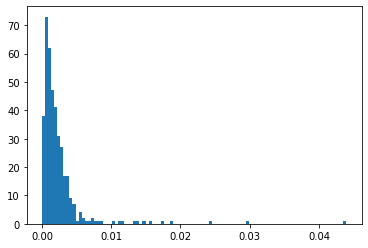

In [54]:
import matplotlib.pyplot as plt
plt.hist(ak.flatten(dR[matches]), bins=100);#, range=(0,7));

In [65]:
t_matched = t[matches]
t_unmatched = t[~matches]
#ak.to_list
print(ak.type(t))
print(ak.num(t))
print(ak.type(t_matched))
print(ak.num(t_matched))
print(ak.type(t_unmatched))
print(ak.num(t_unmatched))

1108 * var * {"pt": float32, "eta": float32, "phi": float32, "mass": float32, "status": int32, "mother": int32, "pdgId": int32}
[0, 0, 2, 0, 0, 2, 0, 2, 0, 2, 2, 4, 2, 2, ... 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 4]
1108 * var * {"pt": float32, "eta": float32, "phi": float32, "mass": float32, "status": int32, "mother": int32, "pdgId": int32}
[0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 2, 1, 1, ... 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2]
1108 * var * {"pt": float32, "eta": float32, "phi": float32, "mass": float32, "status": int32, "mother": int32, "pdgId": int32}
[0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 2, 1, 1, ... 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2]


In [67]:
evt_mask = ak.num(truth_electrons)==2
print(ak.num(truth_electrons))
print(ak.num(reco_electrons))
print(ak.num(pairs))

[2, 0, 2, 0, 0, 2, 0, 2, 0, 2, 2, 2, 2, 2, ... 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2]
[0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 2, 1, 1, ... 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2]
[0, 0, 2, 0, 0, 2, 0, 2, 0, 2, 2, 4, 2, 2, ... 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 4]


In [104]:
@numba.jit
def dr_match(evts_ts, evts_rs, builder):
    # note: allows multiple truths to match 
    # to same reco if they're within 0.05
    for ei in range(len(evts_ts)):
        builder.begin_list()

        rs = evts_rs[ei]
        ts = evts_ts[ei]
        
        for t in ts:
            best_dr=-1
            best_ind=-1
            for ri in range(len(rs)):
                r=rs[ri]
                dr = np.sqrt((t.eta - r.eta)**2 + (t.phi - r.phi)**2)
                if dr<0.05 and (best_dr<0 or dr<best_dr):
                    best_dr=dr
                    best_ind=ri
    
            builder.begin_record()
            builder.field("reco_index")
            builder.append(best_ind)
            builder.end_record()

        builder.end_list()
    return builder

In [105]:
match_builder = dr_match(truth_electrons, reco_electrons, ak.ArrayBuilder())
match_extension = match_builder.snapshot()

In [106]:
matching_truth_mask = match_extension.reco_index >= 0
matching_reco_mask = match_extension.reco_index[matching_truth_mask]
matched_truth = truth_electrons[matching_truth_mask]
unmatched_truth = truth_electrons[~matching_truth_mask]
matched_reco = reco_electrons[matching_reco_mask]

In [107]:
print(ak.type(matching_truth_mask))
print(ak.type(matched_truth))
print(ak.type(unmatched_truth))
print(ak.type(matched_reco))

1108 * var * bool
1108 * var * {"pt": float32, "eta": float32, "phi": float32, "mass": float32, "status": int32, "mother": int32, "pdgId": int32}
1108 * var * {"pt": float32, "eta": float32, "phi": float32, "mass": float32, "status": int32, "mother": int32, "pdgId": int32}
1108 * var * {"dxy": float32, "dxyErr": float32, "dz": float32, "dzErr": float32, "eta": float32, "ip3d": float32, "mass": float32, "phi": float32, "pt": float32, "charge": int32, "pdgId": int32, "genPartIdx": int32, "genPartFlav": uint8}


In [108]:
ak.to_list(match_extension.reco_index)

[[-1, -1],
 [],
 [0, -1],
 [],
 [],
 [0, -1],
 [],
 [-1, 0],
 [],
 [0, -1],
 [0, -1],
 [1, 0],
 [0, -1],
 [0, -1],
 [],
 [-1, 0],
 [-1, -1],
 [0, -1],
 [0, -1],
 [],
 [],
 [],
 [],
 [],
 [],
 [0, -1],
 [],
 [-1, -1],
 [],
 [-1, 0],
 [],
 [0, 1],
 [],
 [-1, 0],
 [],
 [0, 1],
 [-1, 0],
 [-1, -1],
 [],
 [0, -1],
 [],
 [-1, -1],
 [1, -1],
 [-1, -1],
 [],
 [],
 [0, -1],
 [],
 [0, -1],
 [0, 1],
 [0, -1],
 [],
 [],
 [],
 [],
 [],
 [1, 0],
 [],
 [0, -1],
 [0, -1],
 [],
 [],
 [],
 [],
 [],
 [0, -1],
 [],
 [],
 [],
 [],
 [-1, -1],
 [],
 [-1, -1],
 [],
 [0, 1],
 [-1, 0],
 [-1, 0],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [-1, -1],
 [-1, 0],
 [],
 [],
 [],
 [],
 [],
 [0, 0],
 [-1, -1],
 [-1, -1],
 [],
 [],
 [],
 [-1, -1],
 [0, 1],
 [],
 [],
 [0, -1],
 [],
 [0, -1],
 [-1, -1],
 [],
 [-1, 0],
 [-1, -1],
 [-1, -1],
 [],
 [],
 [-1, -1],
 [],
 [-1, -1],
 [-1, -1],
 [-1, -1],
 [],
 [],
 [0, -1],
 [-1, -1],
 [1, 0],
 [],
 [],
 [-1, -1],
 [],
 [0, -1],
 [-1, -1],
 [],
 [],
 [-1, -1],
 

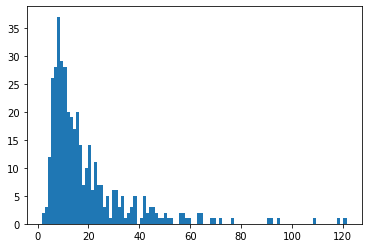

In [109]:
plt.hist(ak.flatten(matched_truth.pt), bins=100);

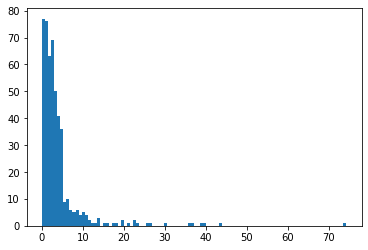

In [110]:
plt.hist(ak.flatten(unmatched_truth.pt), bins=100);

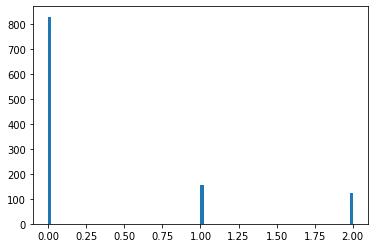

In [111]:
plt.hist(ak.num(matched_truth), bins=100);